In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import shap
import torch
from wordcloud import WordCloud

In [2]:
# Load the data
data_path = '/kaggle/input/political-stance/twinviews-13k.csv'
df = pd.read_csv(data_path)

In [3]:
# Transform the dataset into a format with text and label columns
left_df = df[['left', 'topic']].rename(columns={'left': 'text'})
left_df['label'] = 0
right_df = df[['right', 'topic']].rename(columns={'right': 'text'})
right_df['label'] = 1
stance_df = pd.concat([left_df, right_df], ignore_index=True)

In [4]:
# K-Fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [5]:
# Initialize lists to store the results
accuracies = []
f1_scores = []
precision_scores = []
recall_scores = []

In [6]:
# Simpler models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

In [7]:
# Initialize a dictionary to store confusion matrices for each model
confusion_matrices = {name: [[0, 0], [0, 0]] for name in models} # Initialize confusion_matrices

for train_index, test_index in kf.split(stance_df):
    X_train, X_test = stance_df.iloc[train_index]['text'], stance_df.iloc[test_index]['text']
    y_train, y_test = stance_df.iloc[train_index]['label'], stance_df.iloc[test_index]['label']

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train and evaluate the simpler models
    for name, model in models.items():
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        accuracies.append((name, accuracy))
        f1_scores.append((name, f1))
        precision_scores.append((name, precision))
        recall_scores.append((name, recall))

        # Confusion matrix
        # Convert confusion_matrix output to list for element-wise addition
        cm = confusion_matrix(y_test, y_pred).tolist()
        # Update confusion_matrices using list comprehension
        confusion_matrices[name] = [[confusion_matrices[name][i][j] + cm[i][j] for j in range(len(cm[0]))] for i in range(len(cm))]

        print(f"{name} Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Logistic Regression Accuracy: 0.9791, F1-score: 0.9792, Precision: 0.9785, Recall: 0.9799
Naive Bayes Accuracy: 0.9749, F1-score: 0.9751, Precision: 0.9704, Recall: 0.9799
SVM Accuracy: 0.9866, F1-score: 0.9867, Precision: 0.9881, Recall: 0.9853
Decision Tree Accuracy: 0.9583, F1-score: 0.9582, Precision: 0.9640, Recall: 0.9525
Logistic Regression Accuracy: 0.9829, F1-score: 0.9828, Precision: 0.9797, Recall: 0.9858
Naive Bayes Accuracy: 0.9769, F1-score: 0.9768, Precision: 0.9716, Recall: 0.9822
SVM Accuracy: 0.9897, F1-score: 0.9897, Precision: 0.9863, Recall: 0.9931
Decision Tree Accuracy: 0.9670, F1-score: 0.9669, Precision: 0.9621, Recall: 0.9716
Logistic Regression Accuracy: 0.9809, F1-score: 0.9807, Precision: 0.9822, Recall: 0.9793
Naive Bayes Accuracy: 0.9778, F1-score: 0.9777, Precision: 0.9775, Recall: 0.9779
SVM Accuracy: 0.9879, F1-score: 0.9879, Precision: 0.9870, Recall: 0.9887
Decision Tree Accuracy: 0.9655, F1-score: 0.9653, Precision: 0.9662, Recall: 0.9644
Logistic R

In [8]:
# Print the average performance metrics
print("\nAverage Performance Metrics:")
for metric, scores in [("Accuracy", accuracies), ("F1-score", f1_scores), ("Precision", precision_scores), ("Recall", recall_scores)]:
    print(f"{metric}:")
    for name, score in scores:
        print(f"{name}: {np.mean([s for n, s in scores if n == name]):.4f}")
    print()



Average Performance Metrics:
Accuracy:
Logistic Regression: 0.9812
Naive Bayes: 0.9767
SVM: 0.9885
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9767
SVM: 0.9885
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9767
SVM: 0.9885
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9767
SVM: 0.9885
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9767
SVM: 0.9885
Decision Tree: 0.9646

F1-score:
Logistic Regression: 0.9812
Naive Bayes: 0.9768
SVM: 0.9884
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9768
SVM: 0.9884
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9768
SVM: 0.9884
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9768
SVM: 0.9884
Decision Tree: 0.9646
Logistic Regression: 0.9812
Naive Bayes: 0.9768
SVM: 0.9884
Decision Tree: 0.9646

Precision:
Logistic Regression: 0.9805
Naive Bayes: 0.9732
SVM: 0.9883
Decision Tree: 0.9656
Logistic Regression: 0.9805
Naive B

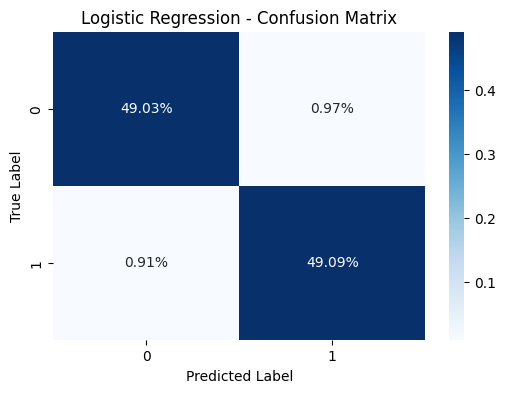

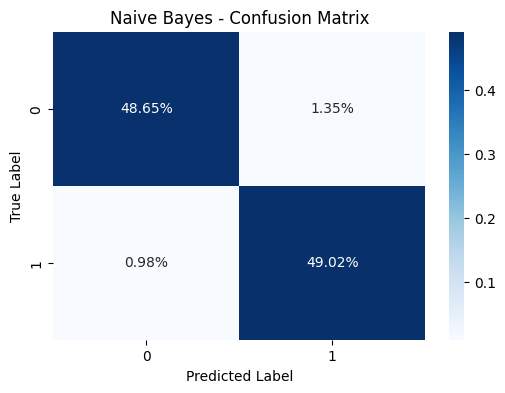

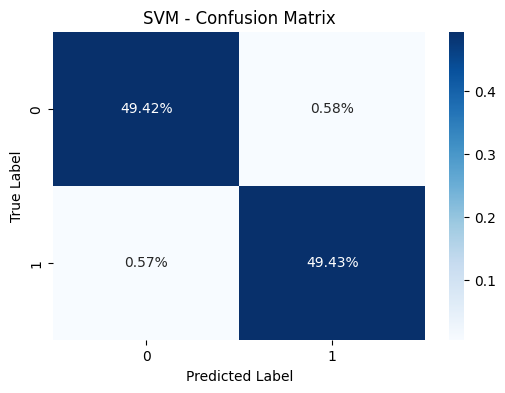

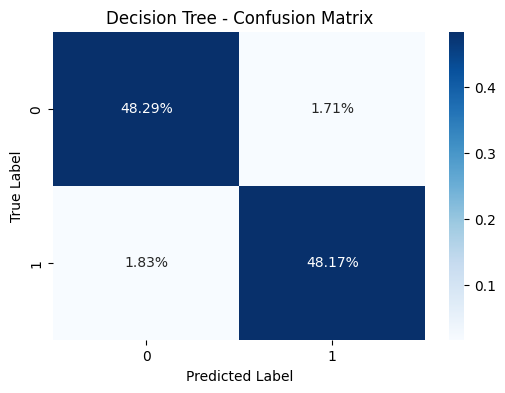

In [9]:
# Plot confusion matrices
for model, cm in confusion_matrices.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'{model} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

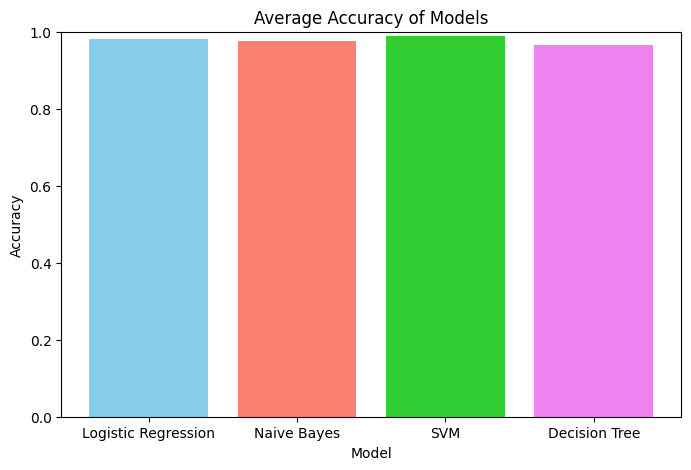

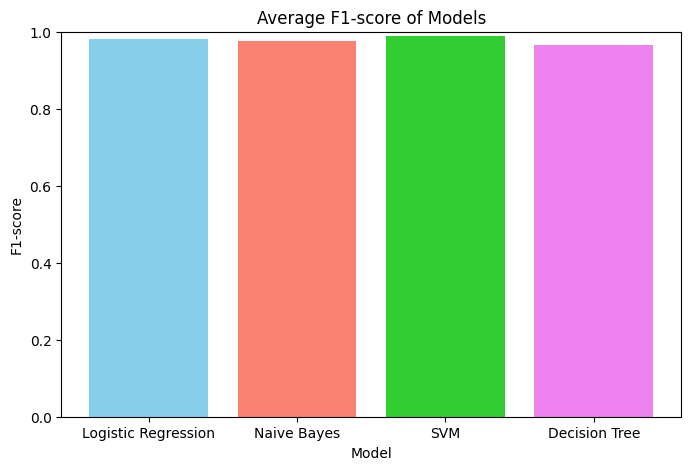

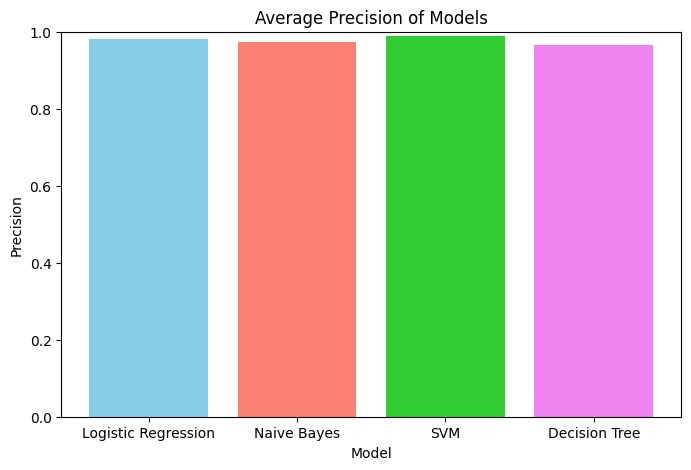

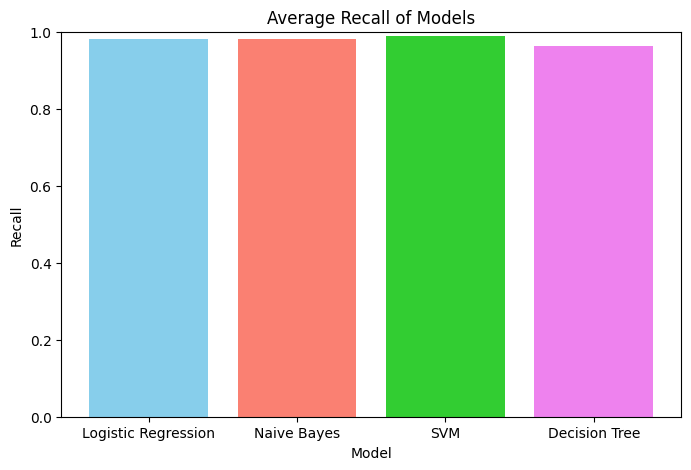

In [10]:
# Plot average performance metrics as bar charts
metrics = {'Accuracy': accuracies, 'F1-score': f1_scores, 'Precision': precision_scores, 'Recall': recall_scores}
for metric, scores in metrics.items():
    avg_scores = {name: np.mean([s for n, s in scores if n == name]) for name in models.keys()}
    plt.figure(figsize=(8, 5))
    plt.bar(avg_scores.keys(), avg_scores.values(), color=['skyblue', 'salmon', 'limegreen', 'violet'])
    plt.title(f'Average {metric} of Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.show()